## Overview
In this notebook, we will run DCON on a DIIID ideal example equilibrium and plot the results

In [ ]:
# Load in necessary packages
using Pkg
using LinearAlgebra
using HDF5
using Plots
using LaTeXStrings

## Run the code
We will run the main DCON code using the inputs specified in `dcon.toml`, `equil.toml`, and `vac.in`. We output the `euler.h5` file, which is a Julia version of the `euler.bin` file.

In [5]:
# Run DCON in Julia
Pkg.activate("../..")
using JPEC
JPEC.DCON.Main("./") # "./" tells us to obtain inputs and direct outputs to our current folder

  Activating project at `~/Github/JPEC`


DCON START
----------------------------------


┌ Info: Forcing pest coordinate jacobian exponents: power_*
└ @ JPEC.Equilibrium /Users/jakehalpern/Github/JPEC/src/Equilibrium/EquilibriumTypes.jl:53


Equilibrium file: sol.toml
Generating Soloviev equilibrium inputs with:
  mr=128, mz=128, ma=128
  e=1.6, a=0.33, r0=1.0
  q0=1.9, p0fac=1.0, b0fac=1.0, f0fac=1.0
--- Starting Direct Equilibrium Processing ---
Finding magnetic axis...
  Iter  1: R = 1.000000, Z = 0.000000, |ΔR|=2.02e-16, |ΔZ|=9.37e-34
Magnetic axis found at R=0.9999999999999998, Z=9.371656600634366e-34.
Finding inboard separatrix crossing...
  Restart attempt 1/6 with initial R = 0.876250
inboard separatrix found at R=0.5830951894666453.
Finding outboard separatrix crossing...
  Restart attempt 1/6 with initial R = 1.123750
outboard separatrix found at R=1.2884098727169977.
Starting loop over flux surfaces...
--> Processing surface ipsi = 128 / 128 (ψ_norm = 1.0000)
--> Processing surface ipsi = 127 / 128 (ψ_norm = 0.9998)
--> Processing surface ipsi = 126 / 128 (ψ_norm = 0.9994)
--> Processing surface ipsi = 125 / 128 (ψ_norm = 0.9986)
--> Processing surface ipsi = 124 / 128 (ψ_norm = 0.9976)
--> Processing surface ip

## Analyze Outputs
We will now analyze the outputs of the run, the most important of which are located in the `euler.h5` output file

In [6]:
# Read in the euler.h5 data
eh5 = h5open("euler.h5", "r")
mlow = read(eh5["info/mlow"])
mpert = read(eh5["info/mpert"])
mstep = read(eh5["integration/nstep"])
u = read(eh5["integration/u"])
ureal = read(eh5["integration/ureal"])
psifac = read(eh5["integration/psi"])
psio = read(eh5["equil/psio"])
wt = read(eh5["vacuum/wt"])
et = read(eh5["vacuum/et"])
close(eh5)

# scale energy eigenvector matrices
chi1 = 2π*psio
wt = wt*(chi1*1e-3)
println("Done reading euler.h5")

Done reading euler.h5


### Plot comparison of xi_psi for a few poloidal mode numbers

In [7]:
# Construct uedge coefficients using the most unstable mode
uedge = u[:,:,1,end] \ wt[:,1]

# Create Julia eigenfunctions
u1s = zeros(ComplexF64, (mstep,mpert))
for istep in 1:mstep
    u1s[istep, :] = ureal[istep, :, :] * uedge
end

p = plot()
for m in 1:5
    plot!(psifac, imag.(u1s[:,m - mlow + 1]), label="m=$m")
end
xlabel!(L"\psi_N")
ylabel!(L"\mathrm{Im}(\xi_\psi)")
title!("Comparison of " * L"\xi_\psi" * " for " * "m=1-5")
display(p)

UndefVarError: UndefVarError: `plot` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name also exists in Plots.
Hint: a global variable of this name also exists in PyPlot.

### Compare the eigenvectors and eigenvalues of each DCON energy matrix eigenmode
This is analagous to the DCON summary plot creating by OMFIT GPEC

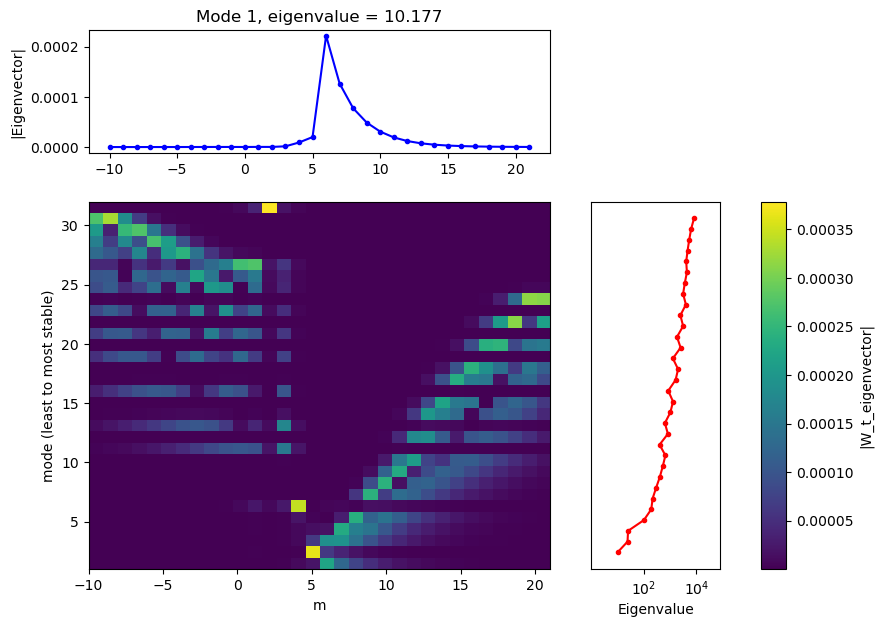

In [ ]:
# I got tired of trying to get the Plots version of this to work, so here's a PyPlot version
using PyPlot

# Axes labels
xlabel = "m"
ylabel = "mode (least to most stable)"

yvals = 1:size(wt, 2)
xvals = (1:size(wt, 1)) .+ (mlow + 1)

# Create figure and grid layout
fig = figure(figsize=(9, 7))
gs = fig.add_gridspec(2, 3, height_ratios=[0.25, 0.75], width_ratios=[0.75, 0.21, 0.04])

# Top-left: Eigenvector amplitude
ax0 = fig.add_subplot(gs[1, 1])
ax0.plot(xvals, abs.(wt[:, 1]), color="blue", marker="o", markersize=3)
ax0.set_ylabel("|Eigenvector|")
ax0.set_xlabel("")
ax0.set_title("Mode 1, eigenvalue = $(round(abs(et[1]), digits=3))")

# Bottom-left: Heatmap
ax1 = fig.add_subplot(gs[2, 1])
im = ax1.imshow(abs.(wt') , aspect="auto", origin="lower",
                cmap="viridis", extent=[xvals[1], xvals[end], yvals[1], yvals[end]])
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)

# Right middle: Eigenvalue amplitude
ax2 = fig.add_subplot(gs[2, 2])
ax2.plot(abs.(et), yvals, color="red", marker="o", markersize=3)
ax2.set_xlabel("Eigenvalue")
ax2.set_xscale("log")
ax2.set_xlim(0.1 * minimum(abs.(et)), 10 * maximum(abs.(et)))
ax2.set_yticks([])

# Colorbar (bottom right)
cax = fig.add_subplot(gs[2, 3])
cb = fig.colorbar(im, cax=cax)
cb.set_label("|W_t_eigenvector|")

# Display and save figure
display(fig)